In [89]:
import pandas as pd
from sqlalchemy import create_engine
import re
from fuzzywuzzy import process
from fuzzywuzzy import fuzz
import difflib
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from itertools import combinations
from matplotlib_venn import venn2, venn3
import squarify

In [115]:
genre_mapping = {
    'Romance': [
        'manwoman relationships fiction', 'romance general', 'fiction romance', 'fiction romance contemporary', 
        'fiction erotica general', 'romance', 'love', 'romantic comedy', 'romantic suspense', 'historical romance', 
        'romance: contemporary', 'romance: historical', 'romance: regency', 'erotica', 'love stories', 'erotic fiction', 
        'fiction romance general', 'dark fantasy', 'fiction romance suspense', 'romance literature', 
        'fiction romance historical general'
    ],
    'Thriller': [
        'fiction thrillers', 'thriller', 'suspense', 'mystery', 'crime', 'detective', 'psychological thriller', 
        'thrillers & suspense', 'fiction thrillers general', 'fiction thrillers suspense', 'action and adventure fiction', 
        'fiction suspense'
    ],
    'Fantasy': [
        'fiction fantasy general', 'fantasy', 'magic', 'witches', 'wizards', 'epic fantasy', 'urban fantasy', 'westerns', 
        'american drama', 'fantasy fiction', 'imaginary places', 'juvenile fantasy fiction'
    ],
    'Science Fiction': [
        'science fiction', 'sci-fi', 'space opera', 'dystopian', 'cyberpunk', 'good and evil', 'time travel', 
        'alternative history'
    ],
    'Historical Fiction': [
        'fiction historical general', 'historical fiction', 'historical', 'world war ii', 'historical mystery', 
        'alternative history'
    ],
    'Young Adult': [
        'young adult', 'teen', 'coming of age', 'ya', 'ya romance', 'teen & young adult', 'young adult fiction', 
        'teenage girls', 'juvenile fiction', 'dark fantasy', 'homosexuality', 'good and evil', 'friendship'
    ],
    'Horror': [
        'horror', 'supernatural', 'vampires', 'zombies', 'ghosts', 'post apocalyptic', 'gothic', 'horror fiction', 
        'horror tales', 'fiction horror'
    ],
    'Mystery': [
        'fiction mystery detective general', 'mystery', 'detective', 'crime', 'cozy mystery', 'whodunit', 'women sleuths', 
        'detective stories', 'mystery and detective stories', 'fiction mystery & detective traditional', 'crime novel'
    ],
    'Adventure': [
        'adventure', 'action', 'quest', 'treasure hunt', 'exploration', 'action & adventure', 'action and adventure fiction', 
        'fiction action adventure'
    ],
    'Literary Fiction': [
        'general literary fiction', 'literary fiction', 'contemporary fiction', 'realistic fiction', 'literature & fiction', 
        'american drama', 'romans, nouvelles', 'epic', 'epic literature', 'novel', 'hindu mythology', 'homosexuality', 
        'fiction in english', 'fiction short stories single author', 
    ],
    'Humor': [
        'humor', 'comedy', 'satire', 'funny', 'parody', 'fiction humorous general'
    ],
    'Biography': [
        'biography', 'autobiography', 'memoir', 'personal memoir', 'life story'
    ],
    'Classics': [
        'classics', 'literature - classics / criticism'
    ],
    'Children': [
        'short stories', 'child and youth fiction', 'comics graphic novels general', 'childrens fiction', 'child', 'children', 
        'comics', 'comic books, strips', 'friendship', 'juvenile', 'family'
    ],
    'Other': [
        'non-classifiable', 'nonclassifiable', 'sale books', 'nonfiction general', 'nonfiction general', 'comics graphic novels general', 'fiction lgbtq gay'
    ]  # Default category for remaining genres
}

In [116]:
def preprocess_genre(genre):
    # Convert to lowercase
    genre = genre.lower()
    # Remove special characters and extra whitespace
    genre = re.sub(r'[^\w\s]', '', genre)
    genre = re.sub(r'\s+', ' ', genre)
    # Split by comma and strip whitespace
    genre_list = [g.strip() for g in genre.split(',') if g.strip()]
    return genre_list

In [117]:
def process_genre(genre):
    # Split the genre string by '||' and remove leading and trailing '|'
    genre_list = [g.strip('|') for g in genre.split('||')]
    return genre_list

In [118]:
def clean_genre(genre_list):
    # Clean up each genre in the genre list
    clean_list = []
    for genre in genre_list:
        # Convert to lowercase
        genre = genre.lower()
        # Remove special characters and extra spaces
        genre = re.sub(r'[^a-zA-Z0-9\s]', '', genre)
        genre = re.sub(r'\s+', ' ', genre).strip()
        clean_list.append(genre)
    return clean_list

In [119]:
def match_genre(genre_labels, genre_mapping, threshold=0.8):
    matched_genres = set()  # Use a set to avoid duplicate categories
    
    # Ensure genre_labels is a list
    if isinstance(genre_labels, str):
        genre_labels = [genre_labels]
    
    # Iterate over each genre label in the list
    for genre_label in genre_labels:
        genre_label_lower = genre_label.lower()
        
        # Exact and substring matching
        for category, values in genre_mapping.items():
            for genre in values:
                genre_lower = genre.lower()
                if genre_lower in genre_label_lower:
                    matched_genres.add(category)
                    break
        
        # Fuzzy matching with difflib
        for category, values in genre_mapping.items():
            for genre in values:
                genre_lower = genre.lower()
                similarity = difflib.SequenceMatcher(None, genre_label_lower, genre_lower).ratio()
                if similarity >= threshold:
                    matched_genres.add(category)
                    break

    # If no match is found, assign the default category "Other"
    if not matched_genres:
        matched_genres.add('Other')
        
    return list(matched_genres)

In [120]:
user = 'root'
password = 'nats'
host = 'localhost'
port = '3306' 
database = 'BookMate'

In [121]:
engine = create_engine(f'mysql+pymysql://{user}:{password}@{host}:{port}/{database}')
query = 'SELECT * FROM book LIMIT 5000'
df_books = pd.read_sql(query, engine)

In [122]:
df_books

,Title,ISBN,Genres,Author,AuthorID,Language
0,Orcas Island mystery,,|Brothers and sisters -- Fiction.||Twins -- Fi...,Jan G. Johnson.,OL67224A,eng\r
1,Say you love me,,|Large type books||England -- Social life and ...,,OL23108A,eng\r
2,Matilda the moocher,,|Borrowing and lending -- Fiction.||Neighbors ...,story and pictures by Diana Cain Bluthenthal.,OL541874A,eng\r
3,World Studies,9780131669697,|People & Places - Africa||Juvenile Nonfiction...,,,eng\r
4,Road from Colonus,9780137816262,Fiction,,OL3368961A,\r
...,...,...,...,...,...,...
4995,Ripped,9781306053228,"|Fiction, romance, general||Man-woman relation...",,OL7024147A,eng\r
4996,Harlequin Desire January 2014,9781306167192,Love stories,,|OL6926891A||OL6932887A||OL7300351A|,eng\r
4997,Snowed In,9781306180757,"|Fiction, romance, suspense||Colorado, fiction|",,OL7389771A,eng\r
4998,Baby and the Bachelor,9781306386807,"Fiction, romance, general",,OL1424279A,eng\r


In [123]:
df_books['genre_list'] = df_books['Genres'].apply(lambda x: process_genre(x))

In [124]:
df_books['clean_genre_list'] = df_books['genre_list'].apply(lambda x: clean_genre(x))

In [125]:
df_books['broad_genre'] = df_books['clean_genre_list'].apply(match_genre, args=(genre_mapping,))

In [126]:
df_books[['Title', 'clean_genre_list', 'broad_genre']]

,Title,clean_genre_list,broad_genre
0,Orcas Island mystery,"[brothers and sisters fiction, twins fiction, ...","[Thriller, Mystery]"
1,Say you love me,"[large type books, england social life and cus...",[Other]
2,Matilda the moocher,"[borrowing and lending fiction, neighbors fict...","[Young Adult, Children]"
3,World Studies,"[people places africa, juvenile nonfiction, ch...","[Young Adult, Children]"
4,Road from Colonus,[fiction],[Other]
...,...,...,...
4995,Ripped,"[fiction romance general, manwoman relationshi...",[Romance]
4996,Harlequin Desire January 2014,[love stories],[Romance]
4997,Snowed In,"[fiction romance suspense, colorado fiction]","[Romance, Thriller]"
4998,Baby and the Bachelor,[fiction romance general],[Romance]


In [127]:
genre_counts = df_books['broad_genre'].value_counts()
top_genres = genre_counts.head(50)
print(top_genres)

broad_genre
[Other]                                             1362
[Children]                                           443
[Romance]                                            438
[Romance, Historical Fiction]                        308
[Thriller, Mystery]                                  299
[Young Adult, Fantasy, Children]                     264
[Young Adult, Children]                              213
[Fantasy]                                            146
[Literary Fiction, Other]                            123
[Literary Fiction]                                   103
[Romance, Thriller]                                   99
[Thriller]                                            84
[Historical Fiction]                                  50
[Horror]                                              49
[Classics]                                            48
[Literary Fiction, Other, Children]                   41
[Humor]                                               40
[Fantasy, Children]

In [128]:
# genre_counts = df_books['clean_genre_list'].value_counts()

In [129]:
# top_genres = genre_counts.head(100)
# print(top_genres)

In [130]:
all_genres = [genre for sublist in df_books['broad_genre'] for genre in sublist]

In [131]:
all_genres

['Thriller',
 'Mystery',
 'Other',
 'Young Adult',
 'Children',
 'Young Adult',
 'Children',
 'Other',
 'Other',
 'Young Adult',
 'Fantasy',
 'Children',
 'Young Adult',
 'Humor',
 'Children',
 'Young Adult',
 'Fantasy',
 'Children',
 'Children',
 'Other',
 'Young Adult',
 'Children',
 'Children',
 'Other',
 'Horror',
 'Children',
 'Other',
 'Historical Fiction',
 'Children',
 'Other',
 'Literary Fiction',
 'Young Adult',
 'Children',
 'Other',
 'Thriller',
 'Mystery',
 'Other',
 'Other',
 'Other',
 'Fantasy',
 'Children',
 'Children',
 'Other',
 'Young Adult',
 'Children',
 'Literary Fiction',
 'Children',
 'Children',
 'Fantasy',
 'Children',
 'Other',
 'Other',
 'Thriller',
 'Mystery',
 'Children',
 'Other',
 'Classics',
 'Thriller',
 'Mystery',
 'Fantasy',
 'Young Adult',
 'Children',
 'Other',
 'Other',
 'Other',
 'Romance',
 'Historical Fiction',
 'Fantasy',
 'Romance',
 'Young Adult',
 'Romance',
 'Young Adult',
 'Romance',
 'Young Adult',
 'Romance',
 'Young Adult',
 'Romance',

In [132]:
genre_counts = Counter(all_genres)
genre_df = pd.DataFrame(genre_counts.items(), columns=['Genre', 'Count'])

In [133]:
genre_df

,Genre,Count
0,Thriller,690
1,Mystery,437
2,Other,1680
3,Young Adult,699
4,Children,1380
5,Fantasy,646
6,Humor,115
7,Horror,126
8,Historical Fiction,506
9,Literary Fiction,422


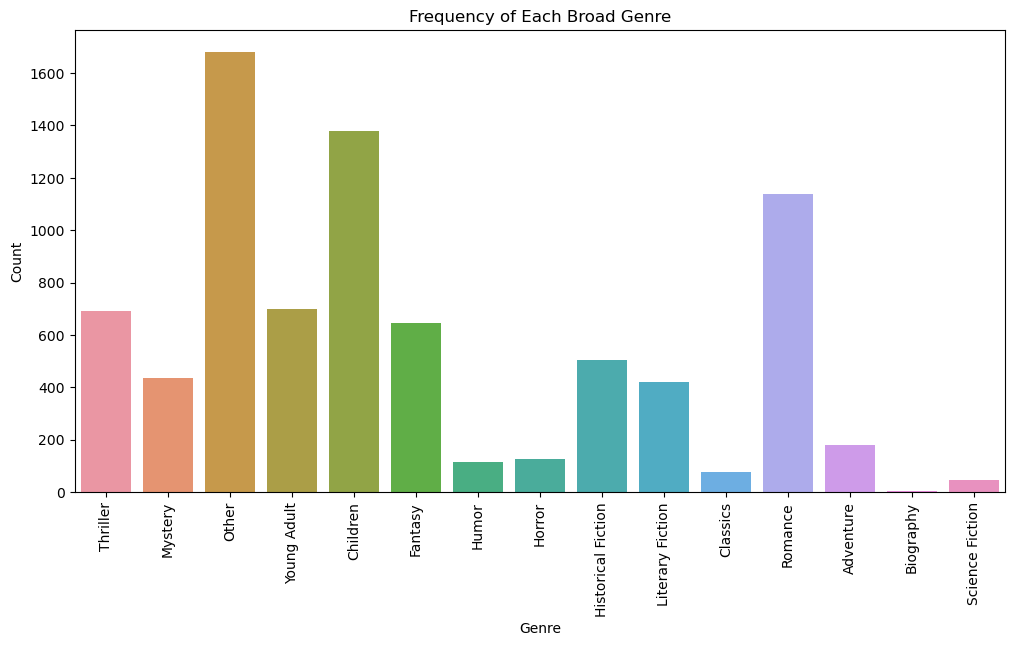

In [134]:
plt.figure(figsize=(12, 6))
sns.barplot(data=genre_df, x='Genre', y='Count')
plt.title('Frequency of Each Broad Genre')
plt.xticks(rotation=90)
plt.show()

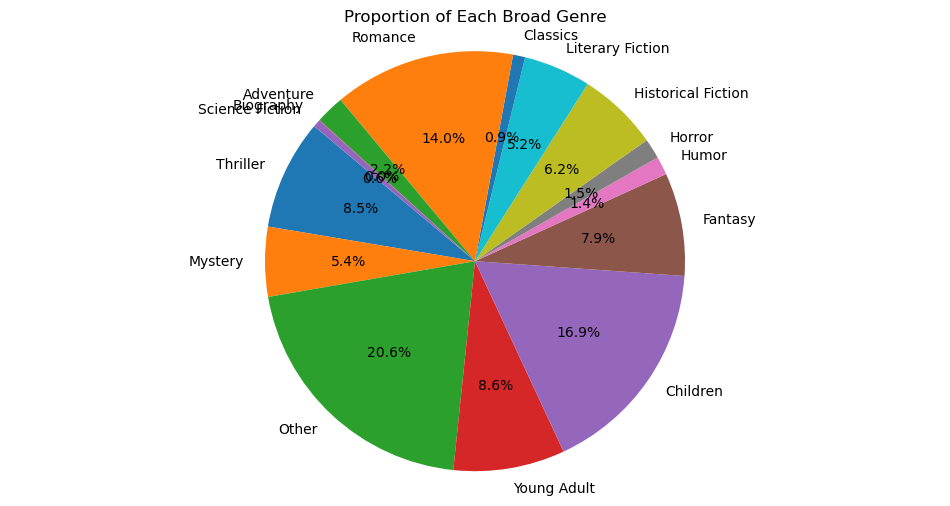

In [135]:
plt.figure(figsize=(12, 6))
plt.pie(genre_df['Count'], labels=genre_df['Genre'], autopct='%1.1f%%', startangle=140)
plt.title('Proportion of Each Broad Genre')
plt.axis('equal')  
plt.show()

In [136]:
overlap_matrix = pd.DataFrame(index=genre_df['Genre'], columns=genre_df['Genre']).fillna(0)
for genres in df_books['broad_genre']:
    for genre1, genre2 in combinations(genres, 2):
        overlap_matrix.at[genre1, genre2] += 1
        overlap_matrix.at[genre2, genre1] += 1

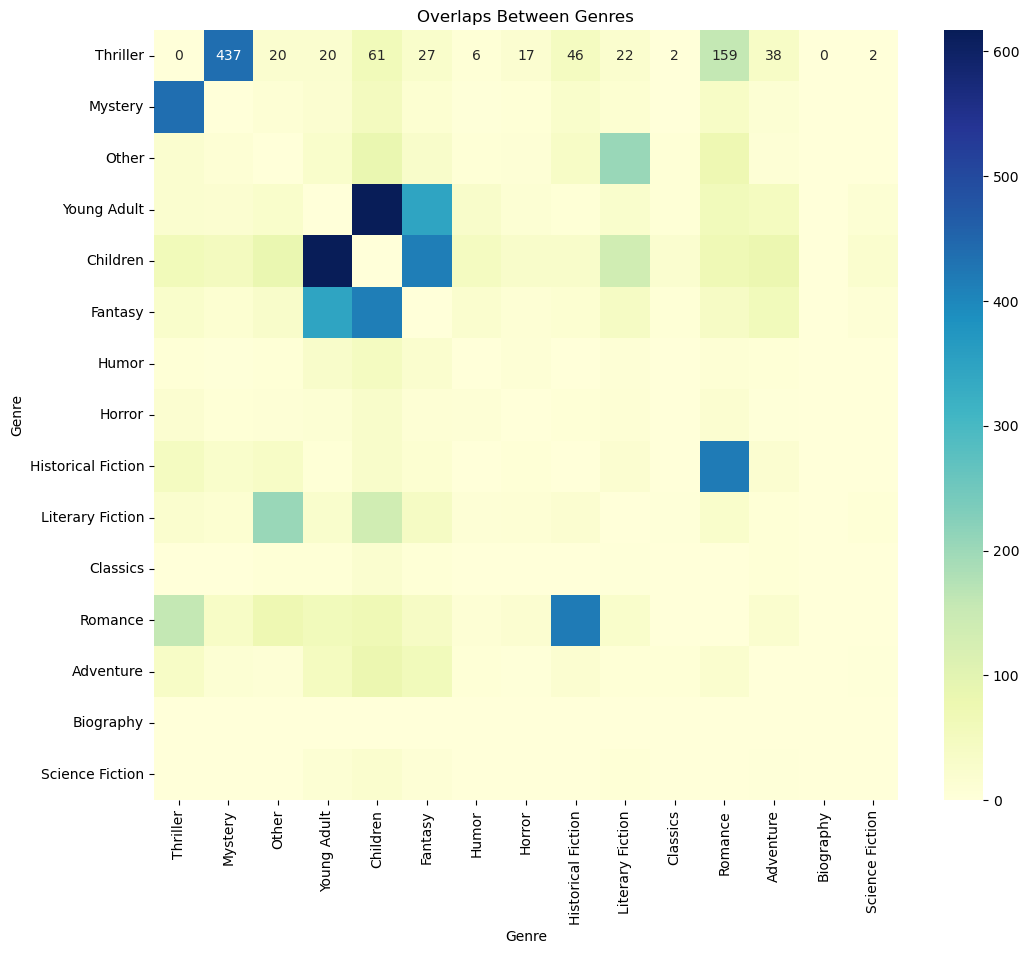

In [137]:
plt.figure(figsize=(12, 10))
sns.heatmap(overlap_matrix, annot=True, fmt="d", cmap="YlGnBu")
plt.title('Overlaps Between Genres')
plt.show()

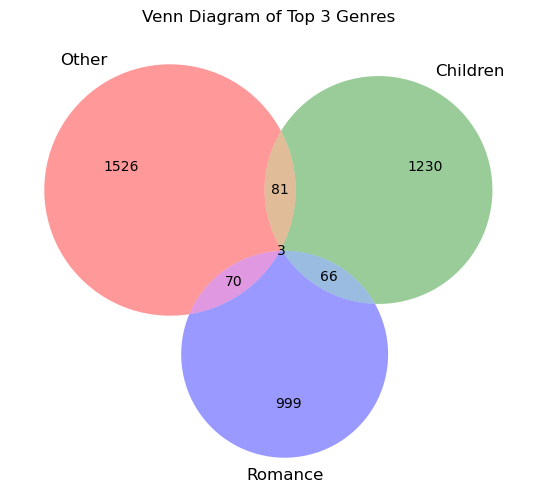

In [138]:
top_genres = genre_df.nlargest(3, 'Count')['Genre']
sets = [set(df_books[df_books['broad_genre'].apply(lambda x: genre in x)].index) for genre in top_genres]

plt.figure(figsize=(10, 6))
venn3(sets, set_labels=top_genres)
plt.title('Venn Diagram of Top 3 Genres')
plt.show()

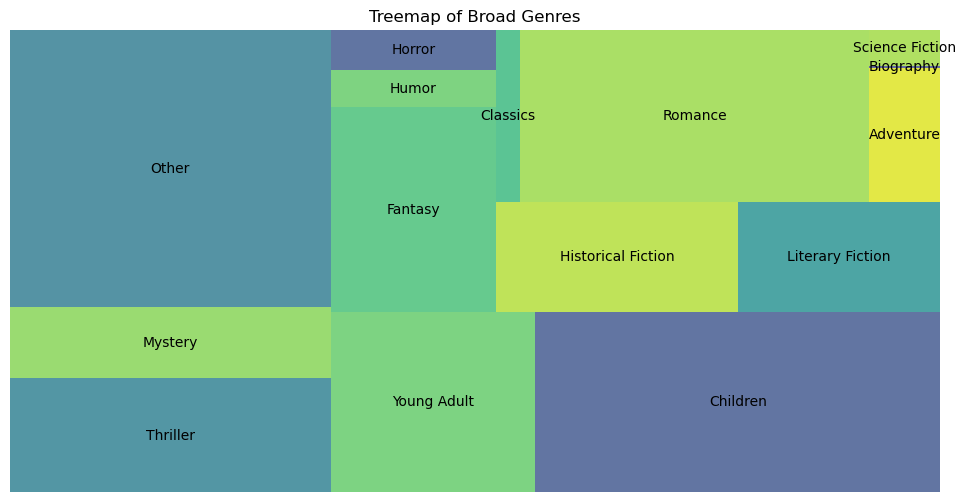

In [139]:
sizes = genre_df['Count']
labels = genre_df['Genre']

plt.figure(figsize=(12, 6))
squarify.plot(sizes=sizes, label=labels, alpha=.8)
plt.title('Treemap of Broad Genres')
plt.axis('off')
plt.show()